### import libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
#import torchsummary
import preprocessing
import cnn

In [ ]:
 conda install -c conda-forge pytorch-model-summary 

failed

CondaError: KeyboardInterrupt


Note: you may need to restart the kernel to use updated packages.


### set device

In [ ]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### set hyperparameters

In [ ]:
#in_channels = 1    # 28x28 = 784, size of MNIST images (grayscale)
#hidden_size = 100
num_classes = 24
learning_rate = 0.001
batch_size = 64
num_epochs = 20

### preprocess data using custom Dataset

In [ ]:
my_transforms = torchvision.transforms.Compose([
    preprocessing.ToTensor(), 
])

training_data = preprocessing.SignDataset(csv_path="data/sign_mnist_train.csv", transform=my_transforms)
test_data = preprocessing.SignDataset(csv_path="data/sign_mnist_test.csv", transform=my_transforms)

### vislualizing the Dataset

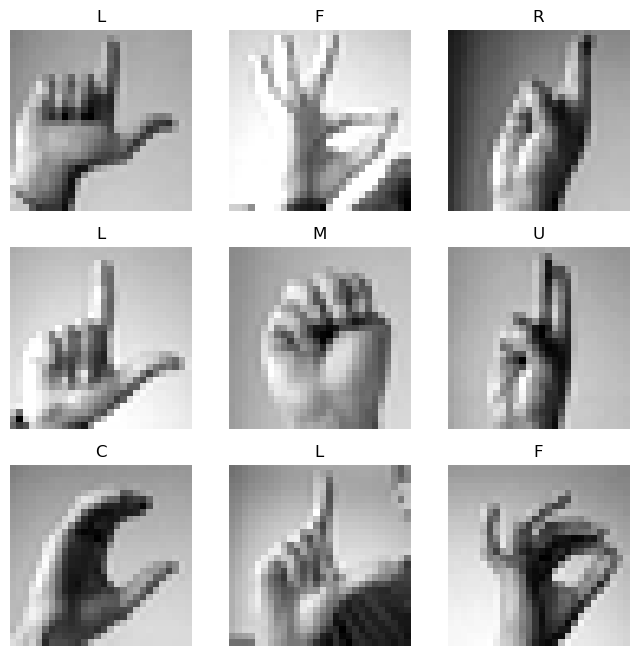

In [ ]:
import matplotlib.pyplot as plt

labels_map = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 
    6: "G", 7: "H", 8: "I", 9: "K", 10: "L", 11: "M",
    12: "N", 13: "O", 14: "P", 15: "Q", 16: "R", 17: "S",
    18: "T", 19: "U", 20: "V", 21: "W", 22: "X", 23: "Y",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label.item()])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### DataLoader

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

### iterate through the DataLoader

Feature batch shape : torch.Size([64, 1, 28, 28])
Labels batch shape  : torch.Size([64])


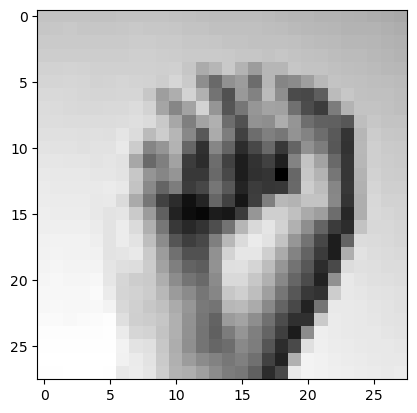

Label: S


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape : {train_features.size()}")
print(f"Labels batch shape  : {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {labels_map[label.item()]}")

### data summary

In [ ]:
print('type(train_dataloader):', type(train_dataloader))
print('----------------------------------')
print('data_iter = iter(train_dataloader)')
data_iter = iter(train_dataloader)
print('----------------------------------')
print('single_batch = data_iter.next()')
single_batch = data_iter.next()
print('type(single_batch) :', type(single_batch))
#print('len(single_batch)  :', len(single_batch))
print('----------------------------------')
print('images, labels = single_batch')
images, labels = single_batch
print('images.shape:', images.shape)
print('labels.shape:', labels.shape)
print('type(labels[0]):', type(labels[0]))

type(train_dataloader): <class 'torch.utils.data.dataloader.DataLoader'>
----------------------------------
data_iter = iter(train_dataloader)
----------------------------------
single_batch = data_iter.next()
type(single_batch) : <class 'list'>
----------------------------------
images, labels = single_batch
images.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
type(labels[0]): <class 'torch.Tensor'>


### Initialize network

In [ ]:
# Create the network and look at it's text representation
net = cnn.ConvNN().to(device)
#torchsummary.summary(net, (1, 28, 28))

### train the model

In [ ]:
trained_model = cnn.train(
    loader=dataloader, 
    model=net, 
    num_epochs=3, 
    learning_rate=learning_rate, 
    device=device
    )

NameError: name 'dataloader' is not defined

### model performance

In [ ]:
cnn.get_accuracy(loader=dataloader, model=trained_model,device=device)
cnn.get_accuracy(loader=dataloader_test, model=trained_model, device=device)

Correct: [15816 / 27455] with accuracy 57.61 %
Correct: [3200 / 7172] with accuracy 44.62 %


In [ ]:
import torch
x = torch.rand(5, 3)
print(x)


tensor([[0.0151, 0.5213, 0.6241],
        [0.3757, 0.7300, 0.0498],
        [0.0396, 0.3449, 0.9364],
        [0.1828, 0.1412, 0.3817],
        [0.2044, 0.1991, 0.6921]])


In [ ]:
torch.version.cuda


'10.2'

In [ ]:
conda install pytorch torchvision torchaudio cudatoolkit=11.6 -c pytorch -c conda-forge

Solving environment: done

## Package Plan ##

  environment location: /home/thomas/miniconda3/envs/tyxe

  added / updated specs:
    - cudatoolkit=11.6
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aom-3.4.0                  |       h27087fc_1         2.7 MB  conda-forge
    ffmpeg-5.1.1               | gpl_hfe78399_101        10.4 MB  conda-forge
    gmp-6.2.1                  |       h58526e2_0         806 KB  conda-forge
    gnutls-3.7.7               |       hf3e180e_0         2.1 MB  conda-forge
    lame-3.100                 |    h7f98852_1001         496 KB  conda-forge
    libdrm-2.4.113             |       h166bdaf_0         286 KB  conda-forge
    libidn2-2.3.3              |       h166bdaf_0         155 KB  conda-forge
    libpciaccess-0.16          |       h516909a_0          37 KB  conda-forge
    libtasn1-4.19.0        